# NMF Practical Work

**Umut Simsekli, Bertrand David, Paul Magron** 

Telecom Paris

In [1]:
import numpy as np

# matplotlib for displaying the output
import matplotlib.pyplot as plt
%matplotlib inline

# and IPython.display for audio output
import IPython.display as ipd

# Librosa for audio
import librosa
# # And the display module for visualization
import librosa.display

import latexify, sys, scipy

<Figure size 640x480 with 0 Axes>

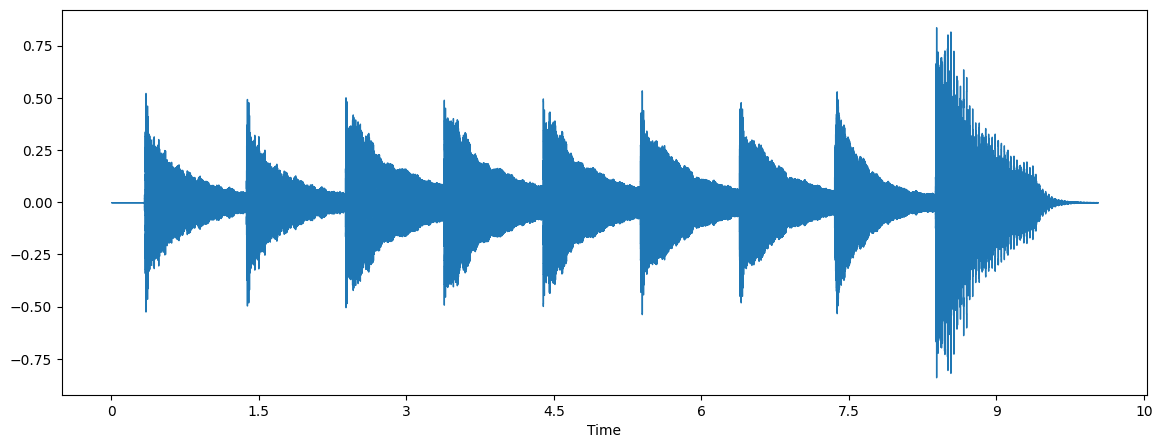

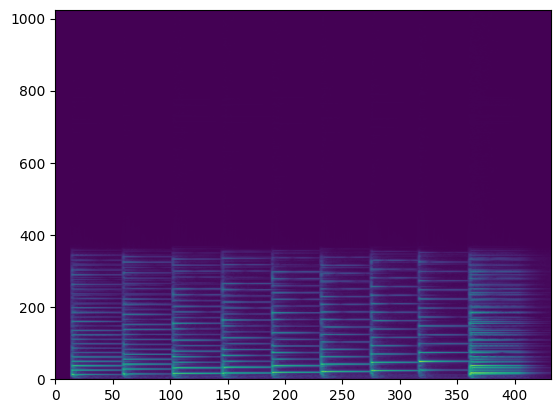

In [2]:
# Audio file
fname = "Cmajor_piano8khz.wav"

# Load signal
y, sr = librosa.load(fname)

# Compute STFT
Xstft = librosa.stft(y, n_fft=2048, hop_length=512, win_length=None)
X = np.abs(Xstft)

# Visualize the waveform
plt.figure()
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.show()

# Visualize the spectrum
plt.figure()
plt.imshow(X**0.3)
plt.gca().invert_yaxis()
plt.axis("auto")
plt.show()

In [4]:
# Example reconstruction
y_hat = librosa.istft(Xstft)
ipd.Audio(y_hat, rate=sr)

In [30]:
def build_signal(notes, Fs):
    """
    %  Signal synthesis from piano isolated notes
    %
    %
    % Inputs :
    %     notes : matrix of notes with 4 lines : pitch, t onset, durations and
    %     velocity
    %     Fs : sample rate (in Hz)
    %
    % Outputs :
    %     x : synthesis signal
    """
    pitch = notes[0, :]
    t_on = notes[1, :]
    durations = notes[2, :]
    vel = notes[3, :]
    Nnotes = len(pitch)
    Lsig = int((t_on[-1] + durations[-1]) * Fs)
    x = np.zeros(Lsig)
    for n in range(Nnotes):
        # Get midi index
        ind_pitch = int(pitch[n])
        Lnote = int(durations[n] * Fs)

        # Read piano note
        xt, sr = librosa.load(f"data/{ind_pitch}.wav")
        xt = librosa.resample(xt, orig_sr=sr, target_sr=Fs)
        xt = xt[:Lnote] * vel[n]

        # Fill the current melodic line
        deb = int(t_on[n] * Fs)
        fin = deb + Lnote
        x[deb:fin] += xt
    return x

# Variantes autour d'un exemple simple

On synthétise d'abord un signal en générant les matrices d'activation et de base ${\bf W}$ et ${\bf H}$.

${\bf \underline{\text{Constantes du problème}}}$

In [6]:
FE = 8000
NFFT = 512
DO3 = 261.63
MI3 = 329.63
LA4 = 440

${\bf \underline{\text{Définition des fonctions}}}$

In [7]:
def spectre_harmonique(f0, NFFT, window, FE):
    freq_reduite = np.linspace(0, 1, NFFT)
    f0_reduite = f0 / FE
    indice_f0 = int(f0_reduite * NFFT)
    spectre = np.zeros(NFFT, dtype=np.complex_)
    semi_len_window = len(window) // 2
    # Rang max des harmoniques Kr*f0 < FE/2
    Kr = np.floor(1 / (2 * f0_reduite)).astype("int")
    for k in range(Kr):
        indice_f_centre = (k + 1) * indice_f0
        debut, fin = (
            indice_f_centre - semi_len_window,
            indice_f_centre + semi_len_window + 1,
        )
        spectre[debut:fin] += np.exp(-k / Kr) * window
    spectre[NFFT // 2 :] = np.flip(spectre[: NFFT // 2])
    return freq_reduite, spectre


# La "matrice MIDI" représente les activation sous forme de 0 et de 1
def activation(delta_T, tau_decroissance, matrice_midi, FE):
    n_points = int(matrice_midi.shape[1] * delta_T * FE)
    n_notes = matrice_midi.shape[0]
    h_activation = np.zeros((n_notes, n_points))
    decroissance_exp = np.exp(-np.arange(0, delta_T, 1 / FE) / tau_decroissance)
    indices_delta_T = len(decroissance_exp)
    for k, br in enumerate(matrice_midi.T):
        debut = k * indices_delta_T
        for note in range(n_notes):
            h_activation[note, debut : debut + indices_delta_T] = (
                br[note] * decroissance_exp
            )
    return h_activation


def mise_a_jour_W(W, H, X, beta):
    X_tilde = W @ H
    return (
        W
        * ((X * np.power(X_tilde, beta - 2)) @ H.T)
        / (np.power(X_tilde, beta - 1) @ H.T)
    )


def mise_a_jour_H(W, H, X, beta):
    X_tilde = W @ H
    return (
        H
        * (W.T @ (X * np.power(X_tilde, beta - 2)))
        / (W.T @ np.power(X_tilde, beta - 1))
    )


def mise_a_jour_globale(W, H, X, beta):
    W = mise_a_jour_W(W, H, X, beta)
    H = mise_a_jour_H(W, H, X, beta)
    vec_norm = np.sum(W, axis=0)
    with np.printoptions(
        edgeitems=np.inf, threshold=sys.maxsize, precision=1, linewidth=np.inf
    ), open("debug.log", "a") as f:
        f.write(
            f"W:\n{W}\nSum W:{np.sum(W)}\nH:\n{H}\nNormalization: {vec_norm}\nMax x: {np.max(X)}, Min x: {np.min(X)}"
        )
    return W, H, (W @ np.diag(vec_norm)) @ (np.diag(1 / vec_norm) @ H)


def beta_div(X, X_tilde, beta):
    if beta == 2:
        return np.sum(
            np.power(X, beta) / (beta * (beta - 1))
            - X * np.power(X_tilde, beta - 1) / (beta - 1)
            + np.power(X_tilde, beta) / beta
        )
    elif beta == 1:
        return np.sum(X * np.log(X / X_tilde) - X + X_tilde)
    elif beta == 0:
        temp = X_tilde / X
        return np.sum(np.log(temp) + temp - 1)
    else:
        print("Beta non pris en compte")
        return

${\bf \underline{\text{Calcul}}}$
On cherche la largeur de la fenêtre. On a une fréquence d'échantillonnage de 8000 Hz et on cherche une fenêtre de largeur 80 Hz.
\begin{align*}
    8000 &\leftrightarrow NFFT\\
    80 &\leftrightarrow \frac{NFFT}{100} \simeq 5 \\
\end{align*}

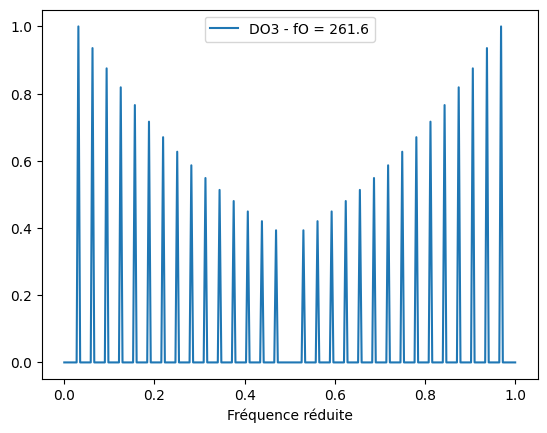

In [8]:
# Calcul de la largeur de fenêtre
largeur_fenetre_frequence = 80
len_window = NFFT * largeur_fenetre_frequence // FE
window_spectre = np.hanning(len_window)
freq_reduite, spectre_do = spectre_harmonique(DO3, NFFT, window_spectre, FE)

plt.plot(freq_reduite, np.abs(spectre_do), label=f"DO3 - fO = {DO3:.1f}")
plt.xlabel("Fréquence réduite")
plt.legend()
plt.show()

La matrice spectrale est la concaténation du spectre de chaque note. Chaque spectre est une colonne de la matrice de base spectrale.

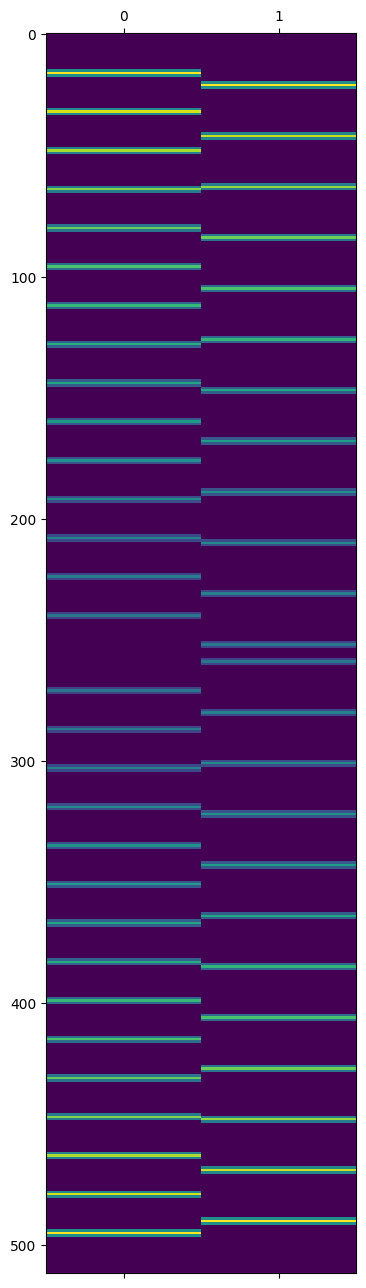

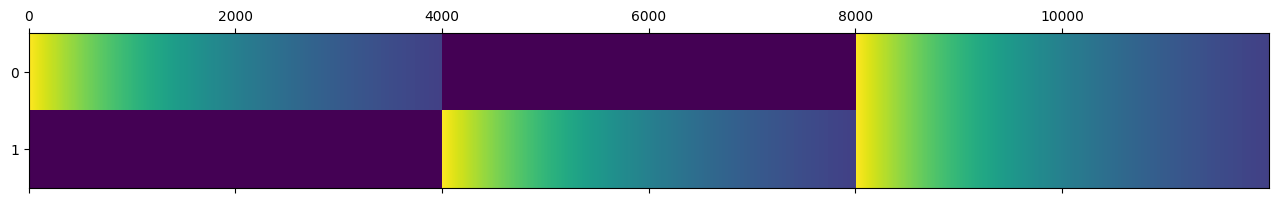

In [9]:
freq_reduite, spectre_mi = spectre_harmonique(MI3, NFFT, window_spectre, FE)
WS = np.concatenate([spectre_do.reshape(NFFT, 1), spectre_mi.reshape(NFFT, 1)], axis=1)
plt.matshow(np.abs(WS))
plt.axis("auto")
plt.show()

# Matrice d'activation pour DO, MI, DO/MI
matrice_MIDI = np.array([[1, 0, 1], [0, 1, 1]])
H = activation(0.5, 0.3, matrice_MIDI, FE)

plt.matshow(H)
plt.axis("auto")
plt.show()

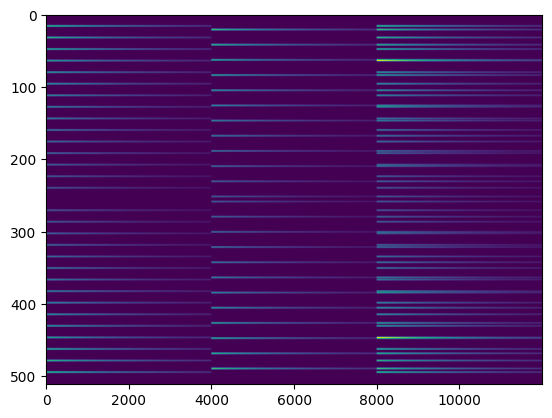

In [10]:
synthese = WS @ H

plt.imshow(np.abs(synthese))
plt.axis("auto")
plt.show()

Tracé de la fonction coùt au fil des ittérations. On initialise les matrices ${\bf W}$ et ${\bf H}$ avec du bruit blanc positif. Pour éviter de diviser par zéro lors des ittérations, on ajoute $\varepsilon = 10^{-12}$ à la matrice initiale $\mathbf{X}$. Pour ne pas biaiser le résultat, on retranche ensuite cette valeur à la matrice $\hat{\mathbf{X}}$ estimée.

In [ ]:
with open("debug.log", "w") as f:
    f.write("")
# On cherche à décomposer la matrice de synthese calculée précédement en matrices positives
n_note = 2
# Initialisation de W et H
W = np.random.rand(synthese.shape[0], n_note)
H = np.random.rand(n_note, synthese.shape[1])

n_iterations = 25
beta = 2
epsilon = 1e-12
loss = np.zeros(n_iterations, dtype=np.complex_)
for k in range(n_iterations):
    W, H, Xtilde = mise_a_jour_globale(W, H, synthese + epsilon, beta)
    loss[k] = beta_div(synthese + epsilon, Xtilde, beta)
X_estime = Xtilde - epsilon
plt.plot(np.abs(loss), label=f"Beta = {beta}")
plt.title(r"Evolution de la $\beta-loss$")
plt.xlabel("Itérations")
plt.legend()
plt.show()

On constate que la loss est strictement décroissante au fil des itérations.

On affiche ensuite la matrice estimée et l'erreur commise par rapport à la matrice de départ.

In [ ]:
plt.imshow(np.abs(X_estime))
plt.axis('auto')
plt.show()
error = np.sum(synthese-X_estime)/np.sum(synthese)
print(f"Error: {100*error.real:.3f}%")

## Variantes

Plusieurs tirages d'initialisations :

In [ ]:
with open("debug.log", "w") as f:
    f.write("")
# On cherche à décomposer la matrice de synthese calculée précédement en matrices positives
n_note = 2
n_iterations = 25
beta = 2
epsilon = 1e-12
# Initialisation de W et H
for i in range(5):
    W = np.random.rand(synthese.shape[0], n_note)
    H = np.random.rand(n_note, synthese.shape[1])
    loss = np.zeros(n_iterations, dtype=np.complex_)
    for k in range(n_iterations):
        W, H, Xtilde = mise_a_jour_globale(W, H, synthese + epsilon, beta)
        loss[k] = beta_div(synthese + epsilon, Xtilde, beta)
    X_estime = Xtilde - epsilon
    plt.plot(np.abs(loss), label=f"Tirage {i+1}")
plt.title(r"Evolution de la $\beta-loss$")
plt.xlabel("Itérations")
plt.legend()
plt.show()

On remarque que suivant l'initialisation la convergence arrive plus ou moins vite. C'est ici une application très simplifiée qui converge dans tous les cas, mais on peut supposer que pour des problèmes plus complexes l'initialisation a une grande importance.

Ajout de bruit :

In [ ]:
with open("debug.log", "w") as f:
    f.write("")
# On cherche à décomposer la matrice de synthese calculée précédement en matrices positives
n_note = 2
# Initialisation de W et H
W_init = np.random.rand(synthese.shape[0], n_note)
H_init = np.random.rand(n_note, synthese.shape[1])

n_iterations = 20
beta = 2
epsilon = 1e-12
for i in range(3):
    W = W_init
    H = H_init
    sigma_bruit = 0.5 ** (i + 1)
    bruit = sigma_bruit * np.random.rand(*synthese.shape)
    loss = np.zeros(n_iterations, dtype=np.complex_)
    for k in range(n_iterations):
        W, H, Xtilde = mise_a_jour_globale(W, H, synthese + epsilon + bruit, beta)
        loss[k] = beta_div(synthese + epsilon + bruit, Xtilde, beta)
    X_estime = Xtilde - epsilon
    plt.plot(np.abs(loss), label=f"Amplitude du bruit = {sigma_bruit}")
plt.title(r"Evolution de la $\beta-loss$")
plt.xlabel("Itérations")
plt.legend()
plt.show()

Différentes valeurs de $\beta$:

In [ ]:
with open("debug.log", "w") as f:
    f.write("")
# On cherche à décomposer la matrice de synthese calculée précédement en matrices positives
n_note = 2
n_iterations = 25
beta = 2
epsilon = 1e-12
W_init = np.random.rand(synthese.shape[0], n_note)
H_init = np.random.rand(n_note, synthese.shape[1])
# Initialisation de W et H
for beta in range(3):
    W = W_init
    H = H_init
    loss = np.zeros(n_iterations, dtype=np.complex_)
    for k in range(n_iterations):
        W, H, Xtilde = mise_a_jour_globale(W, H, synthese + epsilon, beta)
        loss[k] = beta_div(synthese + epsilon, Xtilde, beta)
    X_estime = Xtilde - epsilon
    plt.plot(np.abs(loss), label=rf"$\beta$ = {beta}")
    plt.title(r"Evolution de la $\beta-loss$")
    plt.xlabel("Itérations")
    plt.legend()
    plt.show()

# Transcription automatique avec la NMF supervisée

On commence par construire la matrice spectrale composée de toutes les notes du piano, puis on construit ensuite une gamme à l'aide de la fonction fournie $build\_ signal$.

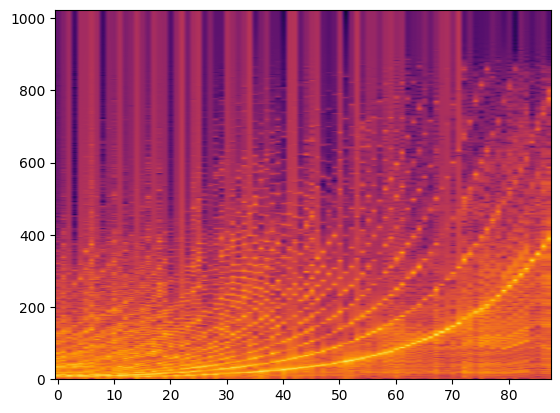

In [29]:
Fs = 22050
n_note = 88
NFFT = 2048
W_piano = np.zeros((NFFT, n_note), dtype=np.complex_)
for k in range(n_note):
    note = k + 21
    file = f"data/{note}.wav"
    data, sr = librosa.load(file)
    if not (sr == Fs):
        data = librosa.resample(data, orig_sr=sr, target_sr=Fs)
    W_piano[:, k] = np.fft.fft(data, NFFT)
plt.imshow(np.log(np.abs(W_piano[: NFFT // 2])), origin="lower", cmap="inferno")
plt.axis("auto")
plt.show()

On crée maintenant le signal de test qui est une gamme de C3 à C4 (48 à 60).

In [35]:
gamme_chroma = [48, 50, 52, 53, 55, 57, 59, 60]
t_on = np.arange(len(gamme_chroma))
duration = 2 * np.ones_like(gamme_chroma)
velocity = np.ones_like(gamme_chroma)
notes = np.concatenate([[gamme_chroma], [t_on], [duration], [velocity]])
son_gamme = build_signal(notes, Fs)
ipd.Audio(son_gamme, rate=Fs)

On applique ensuite la NMF à ce signal en utilisant la matrice spectrale prédéfinie ci-dessus. On ne réactualise que la matrice d'activation. On définie une fonction qui prend en argument une matrice spectrale et un signal, qui calcule la matrice d'activation. On ne travaille que sur les fréquences positives que nous avons gardé précédemment.

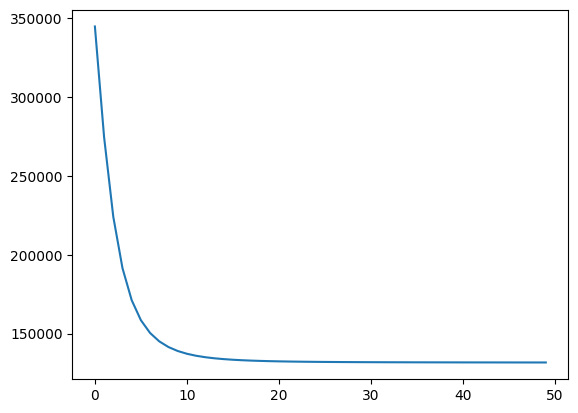

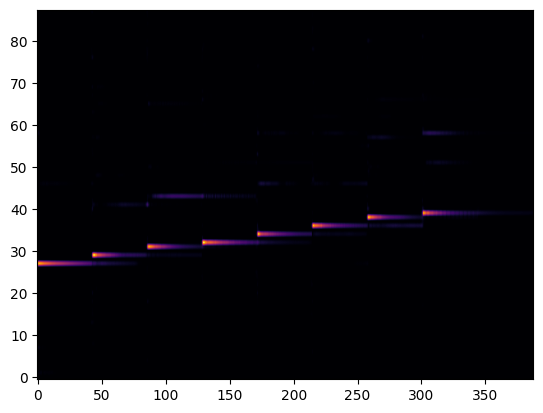

In [61]:
def calcule_activation(W, signal, n_iterations, beta):
    n_fft, n_note = W.shape
    W=W[:n_fft//2+1,:]
    stft = np.abs(librosa.stft(signal, n_fft=n_fft, hop_length=512))
    epsilon = 1e-12
    if np.min(stft)<epsilon:
        stft = stft + epsilon
    H = np.random.rand(n_note, stft.shape[1])
    loss = np.zeros(n_iterations)
    for k in range(n_iterations):
        H = mise_a_jour_H(W=W, H=H, X=stft, beta=beta)
        loss[k] = beta_div(stft, W@H, beta)
    return H, loss
H, loss = calcule_activation(W=np.abs(W_piano), signal=son_gamme, n_iterations=50, beta=1)
plt.plot(loss)
plt.show()

plt.imshow(H, origin="lower", cmap="inferno")
plt.axis('auto')
plt.show()

reconstruction = librosa.istft((W_piano)@H)
ipd.Audio(reconstruction, rate=2*Fs)